In [87]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

import sys
import os
from os import listdir
from os.path import isfile, join
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, LSTM
from keras.regularizers import l1, l2



%matplotlib inline

In [2]:
full_data = pd.read_csv('../../data/train.csv')
test_data = pd.read_csv('../../data/test.csv')

In [3]:
def chunk_data(data, number_of_chunks):
    chunks = list()
    lst = np.linspace(0, len(data), number_of_chunks + 1, dtype = int)
    for start, stop in zip(lst[0:-1], lst[1:]):
        chunks.append(data[start:stop].copy())
    return chunks

def linear_transform(data, slope, intercept):
    data = data.copy()
    data['signal'] = data['signal'] - (slope * data['time'] + intercept)
    return data

def parabolic_transform(data, h, k):
    '''
    vertex formula of parabola (a * (x- h) ^ 2 + k)
    a is the steepnes (same as a in standard form)
    h is the x value of the vertex (time of the center of the chunk)
    k is the y value of the vertex
    
    a = -k / 625
    '''
    data = data.copy()
    data['signal'] = data['signal'] - ((-k / 625) * (data['time'] - h) ** 2 + k)
    return data

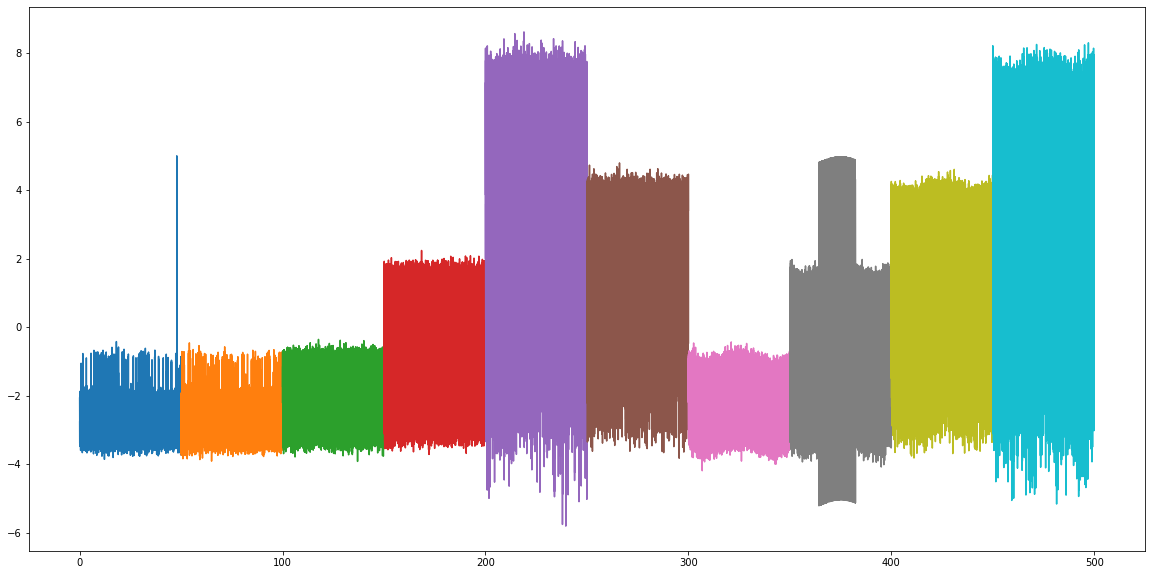

In [4]:
train_chunks = chunk_data(full_data, 10)

train_chunks[1][:100000] = linear_transform(train_chunks[1][:100000], 3 / 10, -15)
train_chunks[6] = parabolic_transform(train_chunks[6], 325, 5.003)
train_chunks[7] = parabolic_transform(train_chunks[7], 375, 5.030)
train_chunks[8] = parabolic_transform(train_chunks[8], 425, 4.974)
train_chunks[9] = parabolic_transform(train_chunks[9], 475, 5.089)

plt.figure(figsize = (20, 10))
for i in train_chunks:
    plt.plot(i['time'], i['signal'])

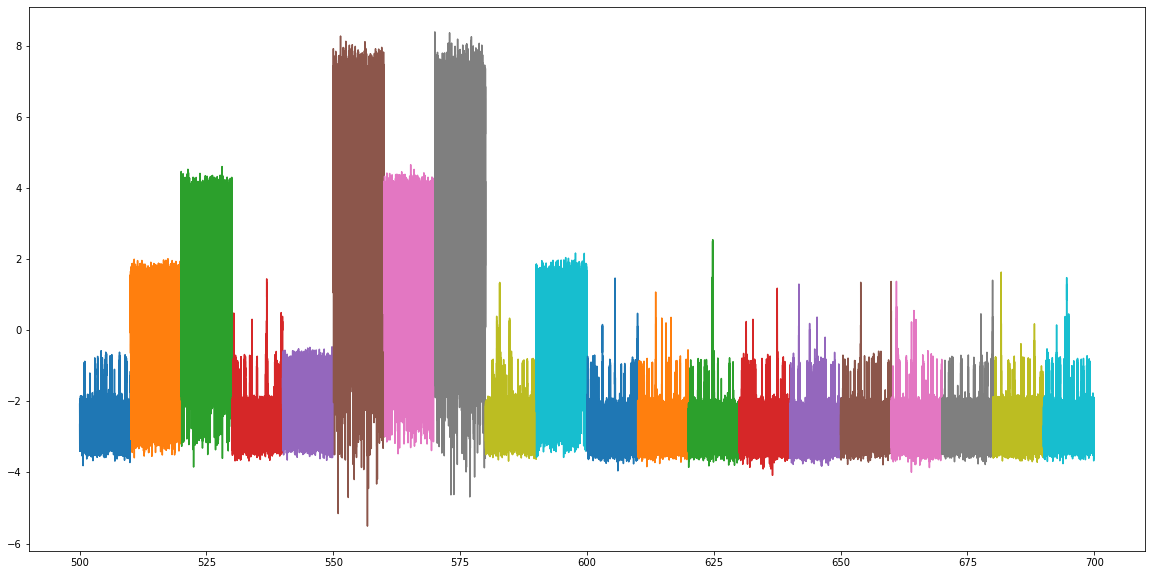

In [5]:
test_chunks = chunk_data(test_data, 4)
test_chunks = chunk_data(test_chunks[0], 5) + chunk_data(test_chunks[1], 5) + test_chunks[2:]

test_chunks[0] = linear_transform(test_chunks[0], 3 / 10, -150)
test_chunks[1] = linear_transform(test_chunks[1], 3 / 10, -153)
test_chunks[4] = linear_transform(test_chunks[4], 3 / 10, -162)
test_chunks[6] = linear_transform(test_chunks[6], 3 / 10, -168)
test_chunks[7] = linear_transform(test_chunks[7], 3 / 10, -171)
test_chunks[8] = linear_transform(test_chunks[8], 3 / 10, -174)
test_chunks[10] = parabolic_transform(test_chunks[10], 625, 4.925)
test_chunks[10]['signal'] -= test_chunks[10]['time'].apply(lambda x: - 0.15 * math.sin(math.pi * 3 * x / 50))

test_chunks = test_chunks[:10] + chunk_data(pd.concat(test_chunks[10:]), 10)

plt.figure(figsize = (20, 10))
for i in test_chunks:
    plt.plot(i['time'], i['signal'])

In [12]:
def make_sliding_window_frame(data, window_size):
    if window_size % 2 == 1:
        raise ValueError('window must be an even number')
    sliding_frame = pd.DataFrame(columns = ['signal' + str(i) for i in range(window_size)] + ['open_channels'])
    sliding_frame['open_channels'] = data['open_channels']
    signal = data['signal']
    nans = pd.Series(np.zeros(window_size // 2))
    signal = pd.concat([nans, signal, nans], ignore_index = True)
    signal = signal
    for index in range(window_size):
        sliding_frame['signal' + str(index)] = signal[index:index - window_size].values
    return sliding_frame

In [13]:
model1_data = pd.concat([train_chunks[0], train_chunks[1]])
model1_data = make_sliding_window_frame(model1_data, 10)

model2_data = pd.concat([train_chunks[2], train_chunks[6]])
model2_data = make_sliding_window_frame(model2_data, 10)

model3_data = pd.concat([train_chunks[3], train_chunks[7]])
model3_data = make_sliding_window_frame(model3_data, 10)

model4_data = pd.concat([train_chunks[5], train_chunks[8]])
model4_data = make_sliding_window_frame(model4_data, 10)

model5_data = pd.concat([train_chunks[4], train_chunks[9]])
model5_data = make_sliding_window_frame(model5_data, 10)

In [200]:
'''
def get_model(data):
    model = Sequential()
    model.add(Dense(22, input_dim = 10, activation = 'relu'))
    model.add(Dense(33, activation = 'relu'))
    model.add(Dense(44, activation = 'relu'))
    model.add(Dense(11, activation = 'softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #model.fit(data.drop(['open_channels'], axis = 1), data['open_channels'], batch_size = 100, epochs = 5)
    return model
#'''

#'''
def get_model(data, time_window_size):
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu',
                         input_shape=(time_window_size, 1)))
    model.add(MaxPooling1D(pool_size=5))
    model.add(Dense(units = time_window_size, activation='linear'))
    model.add(Dense(time_window_size * 2, activation = 'relu'))
    model.add(Dense(11, activation = 'softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
#'''

'''
def get_modelx(data, time_window_size):
    model = Sequential()
    model.add(LSTM(time_window_size * 10, input_shape  = (1, time_window_size)))
    model.add(Dense(40, activation = 'relu', kernel_regularizer = l2(0.01)))
    model.add(Dense(11, activation = 'softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
#''';

In [201]:
model5 = get_model(model5_data, 10)
y =  model5_data['open_channels']
X = model5_data.drop(['open_channels'], axis = 1)
X = X.to_numpy().reshape((X.shape[0], X.shape[1], 1))
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [202]:
X_train.shape

(750000, 10, 1)

In [203]:
history = model5.fit(X_train, y_train, batch_size = 100, epochs = 3)

ValueError: Error when checking target: expected dense_139 to have 3 dimensions, but got array with shape (750000, 1)

In [142]:
f1_score(y_test, model5.predict_classes(X_test), average = 'macro')

0.6844302342068176

In [143]:
model5.predict_classes(X_test)

array([10,  8,  8, ...,  7,  6,  5])

In [11]:
sys.getsizeof(frame) // 1000000

88